# Predicting regional GDP from country GDP
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg

Data locations

In [2]:
loc_shp = "../Data/Shapefile/"
loc_panel = "../Data/Panel/"
loc_wdi = "../Data/WDI/GDPpercapita/"
loc_yields = "../Data/CropYields/"
loc_out = "../Data/Predicted_Regional_GDP/"
loc_gdp_deflator = "../Data/GDP_Deflator/"

Years

In [3]:
y1_in = 1979
y2_in = 2016
years_in = np.arange(y1_in,y2_in+1,1)
y1 = 1992
y2 = 2013
years = np.arange(y1,y2+1,1)

#### Analysis

Shapefile and calculate area

In [4]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})
shp["area"] = shp.to_crs({'proj':'cea'}).geometry.area/10**6

Read panel

In [5]:
edd_type = "month"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)
panel["iso"] = [x[0:3] for x in panel.region.values]

In [6]:
panel_final = panel.loc[(panel.time>=y1)&(panel.time<=y2),:]

Read GDP deflator to convert WDI to 2010 dollars

In [7]:
gdp_deflator = pd.read_csv(loc_gdp_deflator+"API_NY.GDP.DEFL.ZS_DS2_en_excel_v2_4353530.csv")
usa_deflator = gdp_deflator.loc[gdp_deflator["Country Code"]=="USA",:].iloc[:,4:]
usa_deflator_xr = xr.DataArray(usa_deflator.values[0],coords=[np.arange(1960,2021+1,1)],dims=["time"])

target_year = 2010
deflator_ratio = usa_deflator_xr.loc[target_year]/usa_deflator_xr
del([gdp_deflator,usa_deflator,usa_deflator_xr])

Read WDI data

In [8]:
wdi_data = pd.read_csv(loc_wdi+"API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3632113.csv")
wdi_data = wdi_data.drop(columns=["Country Name","Indicator Code","Indicator Name"]).rename(columns={"Country Code":"iso","year":"time"})
yr_wdi = np.arange(1960,2020+1,1)
iso_wdi = wdi_data.iso.values
wdi_xr = xr.DataArray(wdi_data.iloc[:,1:].values,coords=[iso_wdi,yr_wdi],dims=["iso","time"])

In [9]:
wdi_constant = wdi_xr*deflator_ratio.loc[yr_wdi]

In [10]:
# we want to interpolate NA values for a couple countries such as Angola and Iran
# who have continuous data but are just missing a couple entries in 1991/2/3
# but we won't extrapolate outside the data boundaries -- just fill in NA's
# that are in-between existing data
interp_iso = ["AGO","IRN"]
wdi_constant.loc[interp_iso,:] = wdi_constant.loc[interp_iso,:].interpolate_na(dim="time",method="linear")
wdi_constant.name = "gdppc_iso_wdi"
wdi_data_long = wdi_constant.to_dataframe().reset_index()
wdi_data_long["iso"] = [str(x) for x in wdi_data_long.iso.values]
wdi_data_long["time"] = [int(x) for x in wdi_data_long.time.values]

In [11]:
data = pd.merge(panel_final,wdi_data_long,on=["time","iso"],how="left")

Read yields and merge

In [12]:
y1_yields = 1982
y2_yields = 2015
yields = pd.read_csv(loc_yields+"GDHY_mean_yields_region_"+str(y1_yields)+"-"+str(y2_yields)+".csv",index_col=0)

In [13]:
data = pd.merge(data,yields,on=["time","region"],how="left")

Area

In [14]:
data = pd.merge(data,shp.loc[:,["region","area"]],on="region",how="left")

In [15]:
data["log_gdppc_region"] = data.lgdppc_2010*1.0 #data.lgdp_pc_usd*1.0
data["log_gdppc_iso_wdi"] = np.log(data.gdppc_iso_wdi.values)
data["log_pop"] = np.log(data.population.values)
data["area_km1k"] = data.area/1e3
#data["log_yields"] = np.log(data.yields.values)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Set up models and do cross-validation

In [16]:
models = ["Country GDPpc only","Yields only","Nightlights only",
          "Area only","Population only",
          "Country GDPpc and nightlights","Country GDPpc and population",\
          "Country GDPpc and yields","Country GDPpc and area",\
         "Country GDPpc, nightlights, yields, area, population"]
forms = ["log_gdppc_iso_wdi","yields","luminosity",\
        "area_km1k","log_pop","log_gdppc_iso_wdi + luminosity + log_gdppc_iso_wdi*luminosity",\
        "log_gdppc_iso_wdi + log_pop",\
         "log_gdppc_iso_wdi + yields","log_gdppc_iso_wdi + area_km1k",\
         "log_gdppc_iso_wdi + luminosity + log_gdppc_iso_wdi*luminosity + yields + area_km1k + log_pop"]

In [17]:
k = 10 # number of folks
error = np.zeros((k,len(models)))
error_pct = np.zeros((k,len(models)))

In [18]:
cols = ["region","time","iso","log_gdppc_region","log_gdppc_iso_wdi","log_pop",\
        "yields","luminosity","area_km1k"]
data_reg = data.loc[:,cols]

Cross-validation by country

In [19]:
cv_data_regions = data_reg.region.values
cv_data_iso = data_reg.iso.values
iso_uq = np.unique(cv_data_iso)
n_iso = len(iso_uq)

In [20]:
count = 0
kf = KFold(n_splits=int(k),shuffle=True,random_state=100).split(iso_uq)
for train_index, test_index in kf:
    print(count)
    
    # split into training and testing data
    train_countries = iso_uq[train_index]
    test_countries = iso_uq[test_index]
    train_data = data_reg.loc[[x in train_countries for x in cv_data_iso],:]
    test_data = data_reg.loc[[x in test_countries for x in cv_data_iso],:]
    y_actual = test_data.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","yields","luminosity","area_km1k","log_pop"]).log_gdppc_region.values
    
    
    for f in np.arange(0,len(forms),1):
        
        # run model
        train_data = train_data.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","yields","luminosity","area_km1k","log_pop"])
        model_cv = reg("log_gdppc_region ~ "+forms[f],
                   data=train_data).fit(cov_type='cluster',cov_kwds={'groups':train_data['iso']})
    
        # predict
        y_pred = model_cv.predict(test_data.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","yields","luminosity","area_km1k","log_pop"])).values
        rmse = np.sqrt(np.mean(((y_pred - y_actual)**2)))
        error[count,f] = rmse
        error_pct[count,f] = 100*rmse/np.nanmean(data_reg.log_gdppc_region.values)
    count = count+1

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically want

0


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


1


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


2


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


3


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


4


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


5


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


6


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


7


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


8


/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


9


In [21]:
error_pct_mean = np.mean(error_pct,axis=0)
error_pct_std = np.std(error_pct,axis=0)

Plot cross-validation error

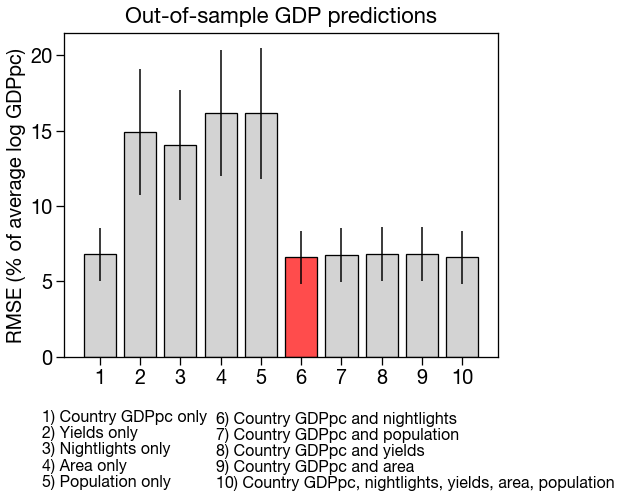

In [22]:
fig = plt.figure(figsize=(9,10))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.13,right=0.8,top=0.9,bottom=0.45,wspace=0.25,hspace=0.3)

ax = plt.subplot(gs1[0,0])

#plt.bar(x=np.arange(1,len(models)+1,1),height=error_pct_mean,
#       facecolor="lightgray",edgecolor="black",linewidth=1.3,
#        yerr=error_pct_std)

for m in np.arange(0,len(models),1):
    if m==np.argmin(error_pct_mean):
        plt.bar(x=[m+1],height=error_pct_mean[m],
               facecolor=[1,0,0,0.7],edgecolor="black",linewidth=1.3,
                yerr=error_pct_std[m])
    else:
        plt.bar(x=[m+1],height=error_pct_mean[m],
               facecolor="lightgray",edgecolor="black",linewidth=1.3,
                yerr=error_pct_std[m])
    txt = str(m+1)+") "+models[m]
    if m < 5:
        plt.text(-0.05,-0.2-(m/20.),txt,transform=ax.transAxes,
                fontsize=16,color="black")
    else:
        plt.text(0.35,-0.155-((m-4)/20.),txt,transform=ax.transAxes,
                fontsize=16,color="black")
        
plt.xticks(ticks=np.arange(1,len(models)+1,1))
#plt.xlabel("Held-out GDPpc quintile (lower = poorer)")
#plt.ylabel("RMS prediction error (log GDPpc)")
#plt.ylim([0,1.1])


plt.ylabel("RMSE (% of average log GDPpc)")
plt.yticks([0,5,10,15,20])
plt.title("Out-of-sample GDP predictions",pad=10,fontsize=22)

plt.savefig("../Figures/FigX_GDP_CrossValidation.pdf")    

plt.show()

In [23]:
models[np.argmin(error_pct_mean)]

'Country GDPpc and nightlights'

Plot predicted vs. actual for our preferred model

In [24]:
"log_gdppc_region ~ "+str(forms[np.argmin(error_pct_mean)])

'log_gdppc_region ~ log_gdppc_iso_wdi + luminosity + log_gdppc_iso_wdi*luminosity'

In [25]:
data_reg_final = data_reg.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","luminosity"])

model = reg("log_gdppc_region ~ log_gdppc_iso_wdi",
           data=data_reg_final).fit(cov_type='cluster',cov_kwds={'groups':data_reg_final['iso']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       log_gdppc_region   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     604.3
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           1.26e-37
Time:                        07:44:38   Log-Likelihood:                -21685.
No. Observations:               24502   AIC:                         4.337e+04
Df Residuals:                   24500   BIC:                         4.339e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.3902      0.39

In [26]:
data_reg_final = data_reg.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","luminosity"])

model = reg("log_gdppc_region ~ "+str(forms[np.argmin(error_pct_mean)]),
           data=data_reg_final).fit(cov_type='cluster',cov_kwds={'groups':data_reg_final['iso']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       log_gdppc_region   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     469.7
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           1.65e-48
Time:                        07:44:38   Log-Likelihood:                -20551.
No. Observations:               24502   AIC:                         4.111e+04
Df Residuals:                   24498   BIC:                         4.114e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Get LaTeX version of table

Plot with and without UZB/KEN

rsquared = 0.8663949445910692
rsquared = 0.8945187923359443


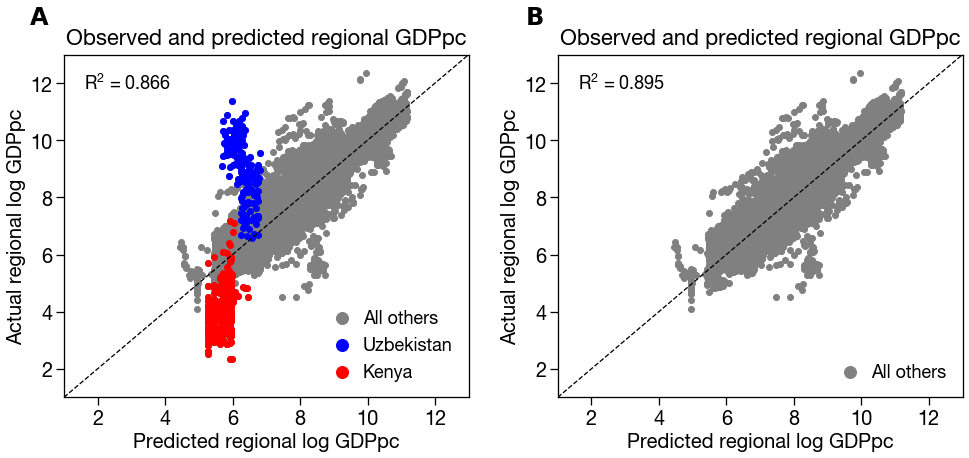

In [27]:
fig = plt.figure(figsize=(16,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.15,right=0.93,top=0.85,bottom=0.17,wspace=0.22,hspace=0.3)

countries_to_drop = ["UZB","KEN"]
nms = ["Uzbekistan","Kenya"]
cols = ["blue","red"]

for j in [0,1]:
    ax = plt.subplot(gs1[0,j])
            
    y_pred_all = model.predict(data_reg_final.loc[:,["log_gdppc_region","log_gdppc_iso_wdi","luminosity"]]).values
    y_pred = model.predict(data_reg_final.loc[[x not in countries_to_drop for x in data_reg_final.iso.values],["log_gdppc_region","log_gdppc_iso_wdi","luminosity"]]).values
    y_actual_all = data_reg_final.loc[:,"log_gdppc_region"].values
    y_actual = data_reg_final.loc[[x not in countries_to_drop for x in data_reg_final.iso.values],"log_gdppc_region"].values
    
    ind = (~np.isnan(y_actual))&(~np.isnan(y_pred))
    ind_all = (~np.isnan(y_actual_all))&(~np.isnan(y_pred_all))
    
    if j == 0:
        y = y_actual_all[ind_all]
        x = y_pred_all[ind_all]
    else:
        y = y_actual[ind]
        x = y_pred[ind]
    
    plt.scatter(x,y,color="gray",label="All others")
    
    if j == 0:
        for cc in np.arange(0,len(countries_to_drop),1):
            x_1 = model.predict(data_reg_final.loc[[x in countries_to_drop[cc] for x in data_reg_final.iso.values],["log_gdppc_region","log_gdppc_iso_wdi","luminosity"]]).values
            y_1 = data_reg_final.loc[[x in countries_to_drop[cc] for x in data_reg_final.iso.values],"log_gdppc_region"].values
            plt.scatter(x_1,y_1,color=cols[cc],label=nms[cc])
            
    slope, intercept, r, pvalue, se = stats.linregress(x,y)
    print("rsquared = "+str(r**2))
    plt.plot([1,13],[1,13],color="black",linewidth=1.3,linestyle="--")
    plt.xlabel("Predicted regional log GDPpc")
    plt.ylabel("Actual regional log GDPpc")
    plt.xlim([1,13])
    plt.ylim([1,13])
    plt.legend(loc="lower right",frameon=False,fontsize=18,
              markerscale=2,handletextpad=0.15)
    plt.title("Observed and predicted regional GDPpc",pad=10,fontsize=22)
    
    plt.text(0.05,0.9,r"R$^2$ = "+str(np.around(r**2,3)),
            transform=ax.transAxes,fontsize=18)
    
plt.figtext(0.12,0.91,r'$\bf{A}$',fontsize=24)
plt.figtext(0.55,0.91,r'$\bf{B}$',fontsize=24)


plt.savefig("../Figures/FigX_GDP_Predictions.pdf")    

plt.show()

Predict overall sample, then integrate lessmann GDP, plot against ours... but also need to bootstrap model and sample residual uncertainty

In [28]:
def indices(x,df):
    return(df.loc[df.iso==x,:].index.values)
def flatten(t):
    return [item for sublist in t for item in sublist]
def sample_by_country(df):
    ## set seed before running function
    iso_df = np.unique(df.iso.values)
    iso_sample = np.random.choice(iso_df,size=len(iso_df),replace=True)
    indices_array = np.array([indices(i,df) for i in iso_sample],dtype="object")
    final_indices = flatten(indices_array)
    df_boot = df.iloc[final_indices,:]
    return(df_boot)

In [29]:
np.random.seed(100)

Set up xarray dataarray with needed dimensions

In [30]:
regions = np.unique(data_reg.region.values)
time = np.unique(data_reg.time.values)
n_uncert = 1000
uncertainty = np.arange(1,n_uncert+1,1)

In [31]:
regional_log_gdppc = xr.DataArray(np.full((len(regions),len(time),n_uncert),np.nan),
                              coords=[regions,time,uncertainty],
                             dims=["region","time","uncertainty"])

Bootstrap 1000 times -- each time, run the model on bootstrapped data to get params, predict on original dataset, then add residual realization

In [32]:
for i in np.arange(0,n_uncert,1):
    if np.mod(i,50)==0:
        print(i)
        
    # bootstrap
    data_boot = sample_by_country(data_reg)
    data_boot_final = data_boot.dropna(subset=["log_gdppc_region","log_gdppc_iso_wdi","luminosity"])

    # fit model
    model = reg("log_gdppc_region ~ log_gdppc_iso_wdi + luminosity + log_gdppc_iso_wdi*luminosity",data=data_boot_final).fit()
    
    # predict
    predicted = model.predict(data_reg)
    
    # generate noise using the variance of the residuals
    std_resid = model.resid.std()
    noise = np.random.normal(loc=0,scale=std_resid,size=len(predicted))
    data_reg["predicted"] = predicted + noise
    regional_log_gdppc[:,:,i] = data_reg.loc[:,["region","time","predicted"]].pivot(index="region",columns="time").values

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


Drop countries that we want to drop

In [33]:
countries_to_drop = ["UZB","KEN"]

In [34]:
regional_log_gdppc.coords["iso"] = xr.DataArray([x[0:3] for x in regions],coords=[regions],dims=["region"])
for c in countries_to_drop:
    regional_log_gdppc = regional_log_gdppc.where(regional_log_gdppc.iso!=c,np.nan)

Write out in dataset

In [35]:
regional_gdppc = np.exp(regional_log_gdppc)

In [36]:
regional_income = xr.Dataset({"log_gdp_per_capita":(["region","time","uncertainty"],regional_log_gdppc),
                              "gdp_per_capita":(["region","time","uncertainty"],regional_gdppc)},
                             coords={"region":(["region"],regions),
                                     "time":(["time"],time),
                                     "uncertainty":(["uncertainty"],uncertainty)})

regional_income.attrs["creation_date"] = str(datetime.datetime.now())
regional_income.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
regional_income.attrs["variable_description"] = "Predicted subnational region GDP per capita predicted using country GDP per capita and luminosity"
regional_income.attrs["created_from"] = os.getcwd()+"/Predict_Regional_GDP.ipynb"
regional_income.attrs["dims"] = "region, time, uncertainty"
regional_income.attrs["uncertainty"] = str(n_uncert)+" monte carlo samples"
regional_income.attrs["inflation_adjustment"] = "constant 2010 dollars"

fname_out = loc_out+"adm1_subnational_constant2010_gdp_percapita_predicted_"+str(y1)+"-"+str(y2)+".nc"
regional_income.to_netcdf(fname_out,mode="w")
print(fname_out,flush=True)

/dartfs-hpc/rc/lab/C/CMIG/ccallahan/Extremes_Economics/Data/Predicted_Regional_GDP/adm1_subnational_constant2010_gdp_percapita_predicted_1992-2013.nc


In [37]:
regional_income

<xarray.Dataset>
Dimensions:             (region: 3610, time: 22, uncertainty: 1000)
Coordinates:
  * region              (region) object 'AFG.10_1' 'AFG.11_1' ... 'ZWE.9_1'
  * time                (time) int64 1992 1993 1994 1995 ... 2010 2011 2012 2013
  * uncertainty         (uncertainty) int64 1 2 3 4 5 6 ... 996 997 998 999 1000
Data variables:
    log_gdp_per_capita  (region, time, uncertainty) float64 nan nan ... 6.918
    gdp_per_capita      (region, time, uncertainty) float64 nan nan ... 1.01e+03
Attributes:
    creation_date:         2022-08-22 08:03:36.494329
    created_by:            Christopher Callahan, Christopher.W.Callahan.GR@da...
    variable_description:  Predicted subnational region GDP per capita predic...
    created_from:          /dartfs-hpc/rc/lab/C/CMIG/ccallahan/Extremes_Econo...
    dims:                  region, time, uncertainty
    uncertainty:           1000 monte carlo samples
    inflation_adjustment:  constant 2010 dollars

Also write out summary statistics for csv

In [62]:
gdp_mean = regional_gdppc.mean(dim="uncertainty")
gdp_std = regional_gdppc.std(dim="uncertainty")
#gdp_ci_lower = regional_gdppc.quantile(0.025,dim="uncertainty").drop("quantile")
#gdp_ci_upper = regional_gdppc.quantile(0.975,dim="uncertainty").drop("quantile")

gdp_mean.name = "gdp_percapita_mean"
gdp_std.name = "gdp_percapita_std"
#gdp_ci_lower.name = "gdp_ci_2.5"
#gdp_ci_upper.name = "gdp_ci_97.5"

regional_income_df = gdp_mean.to_dataframe().reset_index()
regional_income_df = pd.merge(regional_income_df,gdp_std.to_dataframe().reset_index(),how="left",on=["iso","region","time"])
#regional_income_df = pd.merge(regional_income_df,gdp_ci_lower.to_dataframe().reset_index(),how="left",on=["iso","region","time"])
#regional_income_df = pd.merge(regional_income_df,gdp_ci_upper.to_dataframe().reset_index(),how="left",on=["iso","region","time"])

regional_income_df.to_csv(loc_out+"adm1_subnational_constant2010_gdp_percapita_predicted_summarystats_"+str(y1)+"-"+str(y2)+".csv")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
